# Quote recommendation

Create your dataset and train the models for recommendation on unknown sentences.
You can cache the results in order to predict immediatly without re-generating the embedding vectors.

To do, use fast text to pin words, lemma that are not detected by Word2Vec

In [3]:
%load_ext autoreload 
%autoreload 2

import time
import os
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import sys
sys.path.insert(0, '/Users/10972/Documents/NLP_PJ/nlp_recommend/nlp_recommend')
from nlp_recommend.utils.utils import rerank

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to /Users/10972/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/10972/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/10972/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/Users/10972/Documents/NLP_PJ/env/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
from nlp_recommend import LoadData, clean_text

DATASET = 'philosophy'

pd.options.display.max_rows = 1000
pd.options.display.max_colwidth = 500

# corpus = LoadData(dataset=DATASET,random=False, remove_numbered_rows=True, cache=False)
corpus = LoadData(dataset=DATASET, cache=True) 
philo_df = corpus.corpus_df

philo_df = philo_df[['sentence', 'author', 'title', 'tok_lem_sentence']]
philo_df['clean_sentence'] = philo_df['sentence'].apply(lambda x: clean_text(x, only_symbols=True))

print('number of sentences:', len(philo_df))
philo_df.head()

number of sentences: 27946


/Users/10972/Documents/NLP_PJ/env/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,sentence,author,title,tok_lem_sentence,clean_sentence
level_0,,,,,
2194,The great difference between aenesidemus and kant is the difference between the materialist and the believer in subjective reality,Patrick,Sextus Empiricus and Greek Scepticism,"[great, difference, aenesidemus, kant, difference, materialist, believer, subjective, reality]",the great difference between aenesidemus and kant is the difference between the materialist and the believer in subjective reality
2202,The sceptics however reaped none of the benefits of their own system,Patrick,Sextus Empiricus and Greek Scepticism,"[sceptic, however, reaped, none, benefit, system]",the sceptics however reaped none of the benefits of their own system
2203,They remained as it were always on the threshold of possible progress,Patrick,Sextus Empiricus and Greek Scepticism,"[remained, always, threshold, possible, progress]",they remained as it were always on the threshold of possible progress
2205,The inherent weakness of pyrrhonism lay in its psychological inconsistency and in its negative character,Patrick,Sextus Empiricus and Greek Scepticism,"[inherent, weakness, pyrrhonism, lay, psychological, inconsistency, negative, character]",the inherent weakness of pyrrhonism lay in its psychological inconsistency and in its negative character
2213,The very aim of pyrrhonism was an inconsistent one,Patrick,Sextus Empiricus and Greek Scepticism,"[aim, pyrrhonism, inconsistent, one]",the very aim of pyrrhonism was an inconsistent one


In [7]:
from nlp_recommend.models import SentimentCls
weight_dir = '/Users/10972/Documents/NLP_PJ/training'
# cls = SentimentCls(dataset=DATASET, data=philo_df.sentence.values, weight_dir=weight_dir)
# cls.save()

cls = SentimentCls(dataset=DATASET)


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


# Tfid

In [10]:
from nlp_recommend import TfIdfModel
test_sentence = 'I am beautiful flower today'

data = philo_df['tok_lem_sentence'].apply(lambda x: ' '.join(x)) # calling nlp on a string and spaCy tokenizes the text and creates a document object

tfidf_model = TfIdfModel(dataset=DATASET, data=data, weight_dir=weight_dir)
tfidf_model.save_embeddings()

# tfidf_model = TfIdfModel(dataset=DATASET, weight_dir=weight_dir)

# Quote recommendation
best_index = tfidf_model.predict(test_sentence, topk=10)
print(best_index)
best_index, sentiment = cls.match_filter(test_sentence, best_index)
print(philo_df[['sentence', 'author']].iloc[best_index].values)
# print(best_index)

# Title recommendation
res_title = philo_df[['title', 'author']].iloc[best_index].values
print(philo_df[['title', 'author']].iloc[best_index].values)

title = rerank(res_title[:,0])
print('Recommended title', res_title[res_title[:,0]==title][0])

[36589 28096  1663  2532 10797 65665 13980 25652 52514 47214]


IndexError: positional indexers are out-of-bounds

In [5]:
test_sentence = 'I am beautiful flower today'
weight_dir = '/home/bettyld/PJ/Documents/NLP_PJ/training'
data = philo_df['tok_lem_sentence'].apply(lambda x: ' '.join(x)) # calling nlp on a string and spaCy tokenizes the text and creates a document object


# Word2Vec


In [75]:
from nlp_recommend.models.word2vec import Word2VecModel

# word2vec_model = Word2VecModel(dataset=DATASET, data=philo_df.tok_lem_sentence.values, weight_dir=weight_dir)
# word2vec_model.save_embeddings()

word2vec_model = Word2VecModel(dataset=DATASET, weight_dir=weight_dir)


In [77]:
best_index = word2vec_model.predict(test_sentence, topk=3)
best_index, sentiment = cls.match_filter(test_sentence, best_index)

# Quote recommendation
print(best_index)
print(philo_df[['sentence', 'author']].iloc[best_index])

# Title recommendation
res_title = philo_df[['title', 'author']].iloc[best_index].values
print(philo_df[['title', 'author']].iloc[best_index].values)

title = rerank(res_title[:,0])
print('Recommended title', res_title[res_title[:,0]==title][0])

[36589  3739]
                                                 sentence  author
level_0                                                          
87245                          Behold a beautiful flower.  Cousin
8937     Out of unbeautiful noise sprang beautiful music.  Parker
[['Lectures on the true, the beautiful and the good' 'Cousin']
 ['The Principles of Aesthetics' 'Parker']]
Recommended title ['Lectures on the true, the beautiful and the good' 'Cousin']


In [45]:
cls.labels.shape, philo_df.tok_lem_sentence.values.shape

((42487,), (69069,))

# Spacy 

In [79]:
from nlp_recommend.models.spacy import SpacyModel

spacy_model = SpacyModel(dataset=DATASET, data=philo_df['tok_lem_sentence'], weight_dir=weight_dir)
spacy_model.save_embeddings()


spacy_model = SpacyModel(dataset=DATASET, weight_dir=weight_dir)


generating embeddings...


In [86]:
best_index = spacy_model.predict(test_sentence)
best_index
best_index, sentiment = cls.match_filter(test_sentence, best_index)

print(philo_df[['sentence', 'author']].iloc[best_index])
print(sentiment)
print(philo_df[['sentence', 'author']].iloc[best_index])

# Title recommendation
res_title = philo_df[['title', 'author']].iloc[best_index].values
print(philo_df[['title', 'author']].iloc[best_index].values)
if len(res_title)>0:
    title = rerank(res_title[:,0])
    print('Recommended title', res_title[res_title[:,0]==title][0])

/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:42: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


                                                                        sentence  \
level_0                                                                            
145268                          Then would you still say that love is beautiful?   
48594                   Then in wanting the beautiful, love wants also the good?   
156870   Give me a beautiful action and i will imagine one still more beautiful.   

         author  
level_0          
145268    Plato  
48594     Plato  
156870   Cousin  
POSITIVE
                                                                        sentence  \
level_0                                                                            
145268                          Then would you still say that love is beautiful?   
48594                   Then in wanting the beautiful, love wants also the good?   
156870   Give me a beautiful action and i will imagine one still more beautiful.   

         author  
level_0          
145268    Plato  
48594

# Bert

In [6]:
# cpu ~1.7 it/s 
# GPU  ~10it/s
from nlp_recommend.settings import BERT_MODEL, BERT_BATCH_SIZE
from nlp_recommend.models.bert import BertModel
bert_model = BertModel(dataset=DATASET, 
                        topk=3,
                       small_memory=True,
                       bert_model = BERT_MODEL, batch_size=BERT_BATCH_SIZE,
                        device='cpu', weight_dir=weight_dir)
bert_model.fit_transform(philo_df.sentence.values)
bert_model.save_embeddings()
print(BERT_MODEL)


Check weight path at /home/bettyld/PJ/Documents/NLP_PJ/training/weights/philosophy/paraphrase-mpnet-base-v2_philosophy_pretrained_v1.0.pkl
No cache data found, add data argument
you can run fit_transform on your data


Training...: 100%|██████████████████████████| 8633/8633 [44:07<00:00,  3.26it/s]


sentence-transformers/paraphrase-mpnet-base-v2


In [8]:
bert_model = BertModel(dataset=DATASET, topk=3,
                       bert_model=BERT_MODEL,
                       small_memory=True,weight_dir=weight_dir,
                       device='cpu', batch_size=BERT_BATCH_SIZE)


In [88]:
bert_model.predict(test_sentence) # array([9761, 4996, 2196])

array([36643,    27, 33045])

In [91]:
bert_model.embed_mat.shape

torch.Size([42487, 768])

In [9]:
# %%timeit 
# 565 ms 

# test_sentence = 'He foresaw, he ordained, he intended all those actions of men, which we so rashly pronounce criminal.'
print(test_sentence)
best_index = bert_model.predict(test_sentence)
best_index, sentiment = cls.match_filter(test_sentence, best_index)

philo_df[['sentence', 'author']].iloc[best_index]

I am beautiful flower today


NameError: name 'cls' is not defined

In [ ]:
# Difference pretrained/ fine tune


# Finetune Bert
## 1. Create embedding matrix

In [93]:
from nlp_recommend.models.bert import BertModel

fine_tune_dir = '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_psycho_from_paraphrase-mpnet-base-v2'

bert_model = BertModel(dataset=DATASET,
                        topk=3,
                       small_memory=True,
                       data=philo_df.sentence.values,
                       device='cpu',
                       training='finetune-cls',
                       bert_model=fine_tune_dir, batch_size=8)
# bert_model.save_embeddings()

# # bert_model = BertModel(dataset=DATASET)

# from transformers import BertTokenizer
# from transformers import BertModel, pipeline

# output_dir = '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_psycho'

# tokenizer_finetune = BertTokenizer.from_pretrained(output_dir)
# model_finetune = BertModel.from_pretrained(output_dir)

# pipeline_tune = pipeline('feature-extraction', model=model_finetune, tokenizer=tokenizer_finetune)
# np.array(pipeline_tune(test_sentence))[0][0].shape


OSError: Can't load tokenizer for '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_psycho_from_paraphrase-mpnet-base-v2'. Make sure that:

- '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_psycho_from_paraphrase-mpnet-base-v2' is a correct model identifier listed on 'https://huggingface.co/models'

- or '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_psycho_from_paraphrase-mpnet-base-v2' is the correct path to a directory containing relevant tokenizer files



In [65]:
# bert_model.fit_transform(data=philo_df.sentbence.values)

Training...: 100%|██████████████████████████| 1435/1435 [06:13<00:00,  3.84it/s]


In [17]:
bert_model.mat_path

'/home/bettyld/PJ/Documents/NLP_PJ/training/weights/psychology/model_save_philo_psycho_from_paraphrase-mpnet-base-v2_psychology_finetune-cls_v1.0.pkl'

In [18]:
bert_model.model_name

'model_save_philo_psycho_from_paraphrase-mpnet-base-v2'

In [68]:
# bert_model.save_embeddings()


## 2. Use the embeddings 

In [8]:
bert_model = BertModel(dataset=DATASET,
                        topk=3,
                       small_memory=True,
                       data=philo_df.sentence.values,
                       device='cpu',
                       training='finetune-cls',
                       bert_model=fine_tune_dir, batch_size=8)

NameError: name 'BertModel' is not defined

In [36]:

test_sentence = 'The rugby team has lost'
test_sentence = 'I am hungry I see I see'

best_index = bert_model.predict(test_sentence)
print(best_index)
# best_index, sentiment = cls.match_filter(test_sentence, best_index)

philo_df[['sentence', 'author']].iloc[best_index]

[54090 43764 34428]


,sentence,author
level_0,,
129267,_ancient philosophy_ article _xenophanes_ and article _zeno_.,Cousin
103280,See the description of apetae,Aristotle
83134,Under what shining colours does Demosthenes,Hume


# With NSP, MLM pretraining

In [10]:
from nlp_recommend.models.bert import BertModel

fine_tune_dir = '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_nsp_mlm_2_epochs'

bert_model = BertModel(dataset=DATASET,
                        topk=3,
                       small_memory=True,
                       data=philo_df.sentence.values,
                       device='cpu',
                       training='finetune-nsp',
                       bert_model=fine_tune_dir, batch_size=8)
bert_model.fit_transform(data=philo_df.sentence.values)

Some weights of the model checkpoint at /home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/notebook/model_save_philo_nsp_mlm_2_epochs were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Check weight path at /home/bettyld/PJ/Documents/NLP_PJ/training/weights/philosophy/model_save_philo_nsp_mlm_2_epochs_philosophy_finetune-cls_v1.0.pkl
No cache data found, add data argument
you can run fit_transform on your data


Training...: 100%|████████████████████████| 8633/8633 [1:29:13<00:00,  1.61it/s]


In [ ]:
# Training
bert_model.fit_transform(data=philo_df.sentence.values)

In [17]:
# Testing
test_sentence = 'Yes I can'
# test_sentence = 'I am hungry I see I see'

best_index = bert_model.predict(test_sentence)
print(best_index)
# best_index, sentiment = cls.match_filter(test_sentence, best_index)

philo_df[['sentence', 'author']].iloc[best_index]

[  935 38842 67177]


,sentence,author
level_0,,
1162,Coming into consciousness.,Gunn
93699,Though i have said above chap.,Locke
160371,Such a fiction is suicidal ruinous impious.,Plato


# Fusion of models

In [27]:
from nlp_recommend import RandomModel

test_sentence = 'You are useless and slow!'
random_model = RandomModel(dataset=DATASET, cls=cls)


AssertionError: 

In [8]:
best_index, model_choice = random_model.predict(test_sentence)
print(model_choice)
philo_df[['sentence', 'title', 'author']].iloc[best_index]

tfidf


sentence                Slow--people..........
title       A Study of Association in Insanity
author                                    Kent
Name: 4648, dtype: object

# Combined models

In [28]:
from nlp_recommend import CombinedModel

combined_model = CombinedModel(dataset=DATASET)

generating embeddings...


TypeError: 'NoneType' object is not iterable

In [ ]:
test_sentence = 'I would like to live with my girlfriend'

best_index = combined_model.predict(test_sentence)
philo_df[['sentence', 'title', 'author']].iloc[best_index]

# Warper

In [18]:
from nlp_recommend import Warper
warper = Warper(dataset=DATASET)

In [35]:
# test_sentence = 'This is beautiful'

result, warped_sentence  = warper.predict(combined_model, test_sentence)

print(result.values[0], warped_sentence)


['But I need living companions, who will follow me because they want to follow themselves--and to the place where I will.'
 'Nietzsche' 'The Will To Power'] ['At last, however, his eyes opened, and amazedly he gazed into the forest and the stillness, amazedly he gazed into himself', 'Then he arose quickly, like a seafarer who all at once seeth the land; and he shouted for joy: for he saw a new truth', 'And he spake thus to his heart:  A light hath dawned upon me: I need companions--living ones; not dead companions and corpses, which I carry with me where I will', ' But I need living companions, who will follow me because they want to follow themselves--and to the place where I will', ' A light hath dawned upon me', 'Not to the people is Zarathustra to speak, but to companions! Zarathustra shall not be the herd’s herdsman and hound!  To allure many from the herd--for that purpose have I come']


# Testing our best model (combined model)
``Combined model`` is our best model so far. Let's see its performance on our validation set.

In [47]:
from nlp_recommend import CUR_DIR
from tqdm import tqdm

test_path = os.path.join(os.path.dirname(CUR_DIR), 'test.txt')

def open_test(test_path):
    out = []
    with open(test_path) as f:
        sentence_list = f.readlines()
        for sentence in sentence_list:
            out.append(sentence.strip('\n'))
    return out

def run_one_model(model, sentence, topk, warper=None): 
    if warper:
        best_index, warped = warper.predict(model, sentence, return_index=True)
    else:
        best_index = model.predict(sentence, topk)
        warped = []
    best_index, sentiment = cls.match_filter(sentence, best_index)
    if len(best_index) > 0:
        best_index = np.array(best_index)[:topk]
    return best_index, sentiment, warped

def run_on_test(test_path, model_name_list, model_list, topk=1, warper=None, prose=False):
    answer_id, model_name_list_ = [], []
    answer_list, input_list = [], []
    warped_list = []
    sentences = open_test(test_path)
    for sentence in tqdm(sentences):   
        for model_name, model in zip(model_name_list, model_list):
            best_index, sentiment, warped = run_one_model(model, sentence, topk, warper=warper)
            if len(best_index) > 0:
                answer_id.extend(list(range(topk)))
                answer_list.append(best_index[0])
                model_name_list_.extend(np.repeat(model_name, topk))
                input_list.extend(np.repeat(sentence, topk))
                warped_list.append(warped)
        if prose :
            print(sentence, sentiment)
    return model_name_list_, input_list, answer_list, warped_list

def generate_csv(model_name_list_, input_list, answer_list, w_list=[]):
    # Format output
    dict_ = {'model': model_name_list_, 'input':input_list,
             'answer':answer_list}
    if len(w_list)>0:
        dict_['context']= w_list
    df = pd.DataFrame(dict_)
    df.input = df.input.apply(lambda x: x.strip('\n'))
    df['answer_text'] = df.answer.apply(lambda x: philo_df.sentence.iloc[x])
    df_clean = df.loc[df.answer != 0] 
    df_clean['author'] = df_clean.answer.apply(lambda x: philo_df.author.iloc[x])
    df_clean['title'] = df_clean.answer.apply(lambda x: philo_df.title.iloc[x])
    # df = df.drop(columns=['answer'])
    return df_clean 

In [48]:
model_list = [combined_model]
model_name_list = ['combined_model']
warper = Warper()
model_name_list_, input_list, answer_list, w_list = run_on_test(test_path,
                                                        model_name_list,
                                                        model_list,
                                                        topk=1,
                                                       warper=warper)
clean_df = generate_csv(model_name_list_, input_list, answer_list, w_list)
clean_df

100%|███████████████████████████████████████████| 30/30 [00:17<00:00,  1.67it/s]


,model,input,answer,context,answer_text,author,title
0,combined_model,The idea of sharing a meal is important to me.,12485,"[ MEGILLUS: Very good, ATHENIAN: We had got about as far as the establishment of the common tables, which in most places would be difficult, but in Crete no one would think of introducing any other custom, There might arise a question about the manner of them--whether they shall be such as they are here in Crete, or such as they are in Lacedaemon--or is there a third kind which may be better than either of them? The answer to this question might be easily discovered, but the discovery would...","Now there is only one way of taking care of things, and this is to give to each the food and motion which are natural to it.",Plato,Phaedrus
1,combined_model,"Although necessary, quarantine is not easy to handle.",16315,None,Let everything have a guard as far as possible.,Plato,Phaedrus
2,combined_model,Next door construction works are an unbearable sonore disturbance.,34095,"[In section vii, I now return to the subject because i believe that so far from invalidating my general thesis these phenomena when properly analyzed afford it powerful support.' ""the central point of the pure-experience theory is that 'outer' and"" ""'inner' are names for two groups into which we sort experiences"" 'according to the way in which they act upon their neighbors, Any one' ""'content,' such as _hard_ let us say can be assigned to either group."" ""in the outer group it is 'strong,' it...",Here whatever is hard interferes with the space its neighbors occupy.,James,Essays in Radical Empiricism
3,combined_model,"It's a joy to meet the one you love, especially when it happens to be a surprise.",9566,"[When they meet, the wanton steed of the lover has a word to say to the charioteer; he would like to have a little pleasure in return for many pains, but the wanton steed of the beloved says not a word, for he is bursting with passion which he understands not;--he throws his arms round the lover and embraces him as his dearest friend; and, when they are side by side, he is not in a state in which he can refuse the lover anything, if he ask him; although his fellow-steed and the charioteer op...","They too are dear, but not so dear to one another as the others, either at the time of their love or afterwards.",Plato,Phaedrus
4,combined_model,Can you force a population to get vaccinated?,9700,"[Now will the city have to fill and swell with a multitude of callings which are not required by any natural want; such as the whole tribe of hunters and actors of whom one large class have to do with forms and colours; another will be the votaries of music--poets and their attendant train of rhapsodists players dancers,' ""contractors; also makers of divers kinds of articles including women's"" 'dresses, And we shall want more servants, Will not tutors be also in request and nurses wet and dr...",And living in this way we shall have much greater need of physicians than before?,Plato,Phaedrus
5,combined_model,Will mass tourism come back stronger once covid crisis is over?,3509,"[ [48] It is computed in the West Indies that a stock of slaves grow worse five per cent, every year unless new slaves be bought to recruit them, They are not able to keep up their number even in those warm countries where clothes and provisions are so easily got, How much more must this happen in European countries, and in or near great cities? [49] Corn, Nepos in _Vita Attici_, We may remark that Atticus’s estate lay chiefly in Epirus, which being a remote, desolate place, would render ...","How much more must this happen in European countries, and in or near great cities?",Hume,The History Of England
6,combined_model,Japanese summer is hot and humid but the population is used to it.,17846,None,This takes place at the beginning of summer.,Aristotle,The Athenian Constitution
7,combined_model,People date and meet less people during the crisis.,33539,"[In pioneer times for exam

# Testing All models
We test all models on the validation set.

In [80]:
test_path = os.path.join(os.path.dirname(CUR_DIR), 'test.txt')

model_list = [tfidf_model, word2vec_model, spacy_model, bert_model, combined_model]
model_name_list = ['tfidf_model', 'word2vec_model', 'spacy_model', 'bert_model', 'combined_model']

warper = Warper()
model_name_list_, input_list, answer_list, w_list = run_on_test(test_path,
                                                        model_name_list,
                                                        model_list,
                                                        topk=1,
                                                       warper=warper)

clean_df = generate_csv(model_name_list_, input_list, answer_list, w_list)
clean_df

/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Auguste_Comte_and_Positivism.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
You must keep law. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Bergson_and_His_Philosophy.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Bergson_and_His_Philosophy.txt
Should I publish this video? NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I don't like my body. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Psychology_of_Nations_A_Contribution_to_the_Philosophy_of_History.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I am pregnant but I don't want to. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
My friends hurt me. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Three_Dialogues_Between_Hylas_and_Philonous_in_Opposition_to_Sceptics_and_Atheists.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I am nothing. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Analysis_of_Mind.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
How can I be successful? NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I had an argument with my father. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Thus_Spake_Zarathustra:_A_Book_for_All_and_None.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
My boyfriend broke up with me. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
Give me money! NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
I want to beat down all the people insulting me. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
_A_Study_of_Zen_Philosophy_and_Discipline_in_China_and_Japan.txt_the_Samurai
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
Why this world is so violent? NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Laughter:_An_Essay_on_the_Meaning_of_the_Comic.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Laughter:_An_Essay_on_the_Meaning_of_the_Comic.txt
Give me a recipe. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
I don't know how to earn respect. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Lectures_on_the_true,_the_beautiful_and_the_good.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Lectures_on_the_true,_the_beautiful_and_the_good.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
Today was beautiful. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Thus_Spake_Zarathustra:_A_Book_for_All_and_None.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
My father forced me to eat carot. I hate carots. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I am very limited but I will do my best. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Literary_and_Philosophical_Essays:_French,_German_and_Italian.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/A_New_Philosophy:_Henri_Bergson.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I got a high score today. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Critical_Miscellanies_(Vol._3_of_3),_Essay_10:_Auguste_Comte.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Bacon.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Principles_of_Aesthetics.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
My business is finally successful. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/A_History_of_Indian_Philosophy,_Volume_1.txt
I want to be more calm but my anger won't stop. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
This is the end. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Psychology_of_Nations_A_Contribution_to_the_Philosophy_of_History.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Analysis_of_Mind.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
I want to be rich. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I am the best. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/An_Interpretation_of_Rudolf_Eucken's_Philosophy.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Bacon.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/An_Interpretation_of_Rudolf_Eucken's_Philosophy.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Apology.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/A_History_of_Indian_Philosophy,_Volume_1.txt
My life is a disaster. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Principles_of_Aesthetics.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I deserve to die. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Three_Dialogues_Between_Hylas_and_Philonous_in_Opposition_to_Sceptics_and_Atheists.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
Everyone is wrong about me. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Lectures_on_the_true,_the_beautiful_and_the_good.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
This summer is very nice. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Analysis_of_Mind.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I want to become a pilot of formula 1. NEGATIVE
_A_Study_of_Zen_Philosophy_and_Discipline_in_China_and_Japan.txt_the_Samurai
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/A_History_of_Indian_Philosophy,_Volume_1.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
_A_Study_of_Zen_Philosophy_and_Discipline_in_China_and_Japan.txt_the_Samurai
_A_Study_of_Zen_Philosophy_and_Discipline_in_China_and_Japan.txt_the_Samurai
I want to change the world today. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Ethics_of_Aristotle.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Philosophy_and_Religion_Six_Lectures_Delivered_at_Cambridge.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Philosophy_and_Religion_Six_Lectures_Delivered_at_Cambridge.txt
I don't know what is right or wrong. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
Should I quit my job? NEGATIVE
_A_Study_of_Zen_Philosophy_and_Discipline_in_China_and_Japan.txt_the_Samurai
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Ethics_—_Part_3.txt
My children are a pain. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Psychology_of_Nations_A_Contribution_to_the_Philosophy_of_History.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_English_Utilitarians,_Volume_1_(of_3).txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Analysis_of_Mind.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
I want to fast diet, but I don't have the will... NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/An_Introduction_to_Philosophy.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Critique_of_Pure_Reason.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
The idea of sharing a meal is important to me. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
Although necessary, quarantine is not easy to handle.  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Lectures_on_the_true,_the_beautiful_and_the_good.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Analysis_of_Mind.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Essays_in_Radical_Empiricism.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Essays_in_Radical_Empiricism.txt
Next door construction works are an unbearable sonore disturbance.  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
It's a joy to meet the one you love, especially when it happens to be a surprise.  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Moral_Principles_in_Education.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Republic.txt
Can you force a population to get vaccinated?  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/_.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt
Will mass tourism come back stronger once covid crisis is over?  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_History_Of_England.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Categories.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Athenian_Constitution.txt
Japanese summer is hot and humid but the population is used to it.  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Political_Ideals.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/An_Introduction_to_Philosophy.txt
Is this risky to go through the creation of a start-up?  NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Considerations_on_Representative_Government.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Democracy_and_Education:_An_Introduction_to_the_Philosophy_of_Education.txt
People date and meet less people during the crisis. NEGATIVE
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Ethics_of_Aristotle.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt


/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/nlp_recommend/models/spacy.py:37: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  mat = np.array([doc_test.similarity(line) for line in self.embed_mat])


/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_English_Utilitarians,_Volume_1_(of_3).txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/Phaedrus.txt
/home/bettyld/PJ/Documents/NLP_PJ/data/gutenberg/The_Will_To_Power.txt
What a pleasure to find some good quality products again! NEGATIVE


/home/bettyld/PJ/Documents/NLP_PJ/env/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,model,input,answer,answer_text,author
0,tfidf_model,You must keep law.,15822,We must do so.,Plato
1,word2vec_model,You must keep law.,28937,It must be read to be appreciated.,Mill
2,spacy_model,You must keep law.,12526,"I want to know who the person is, who, in the first place, knows the laws.",Plato
3,bert_model,You must keep law.,3575,"Your answer is, because we should keep our word.",Hume
4,tfidf_model,Should I publish this video?,37877,I am not sure that i shall ever publish anything on this subject.,Gunn
5,word2vec_model,Should I publish this video?,29609,For if he does not look ahead he is more likely to find himself blocked.,Dewey
6,spacy_model,Should I publish this video?,23015,is it really that puts questions to us here?,Nietzsche
7,bert_model,Should I publish this video?,12140,And this speech is addressed to a crowd of people?,Plato
8,combined_model,Should I publish this video?,37877,I am not sure that i shall ever publish anything on this subject.,Gunn
9,tfidf_model,I don't like my body.,9309,And each of them is such as his like is?,Plato


# Analyzing the results on the previous model benchmarking

In [76]:
result = '/home/bettyld/PJ/Documents/NLP_PJ/nlp_recommend/test_results.csv'
res_df = pd.read_csv(result)
res_df.head()

,Sentences,winner_model,loser_model,winner_answer
0,You must keep law.,spacy,bert,"I want to know who the person is, who, in the first place, knows the laws."
1,Should I publish this video?,word2vec,bert,For if he does not look ahead he is more likely to find himself blocked.
2,I don't like my body,spacy,bert,NaN
3,I am pregnant but I don't want to.,tfidf,word2vec,NaN
4,My friends hurt me.,spacy,tfidf,NaN


<AxesSubplot:>

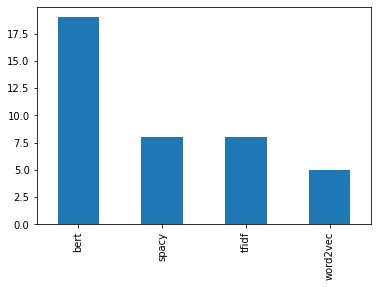

In [77]:
res_df['winner_model'].value_counts().plot(kind='bar')

<AxesSubplot:>

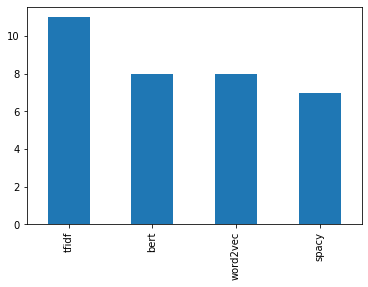

In [78]:
res_df['loser_model'].value_counts().plot(kind='bar')


In [79]:
best_models = res_df['winner_model'].value_counts() - res_df['loser_model'].value_counts()